In [1]:
# cargar librerias
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime
import missingno as msno
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
import statistics as stats

C:\Users\mafer\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.options.display.float_format = '{:.2f}'.format

In [3]:
df= pd.read_csv("/Users/mafer/Documents/Proyectos/RESAGEBURB_09CSV20.csv", dtype={'AGEB':str,'ENTIDAD': str,'MUN': str,'LOC': str, 'MZA': str})
df.shape

C:\Users\mafer\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (178) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(65649, 229)

In [4]:
df.head()

ENTIDAD           NOM_ENT  MUN                               NOM_MUN   LOC  \
0      09  Ciudad de México  000  Total de la entidad Ciudad de México  0000   
1      09  Ciudad de México  002                          Azcapotzalco  0000   
2      09  Ciudad de México  002                          Azcapotzalco  0001   
3      09  Ciudad de México  002                          Azcapotzalco  0001   
4      09  Ciudad de México  002                          Azcapotzalco  0001   

                        NOM_LOC  AGEB  MZA   POBTOT   POBFEM  ... VPH_TELEF  \
0           Total de la entidad  0000  000  9209944  4805017  ...   1898265   
1           Total del municipio  0000  000   432205   227255  ...     96128   
2  Total de la localidad urbana  0000  000   432205   227255  ...     96128   
3             Total AGEB urbana  0010  000     3183     1695  ...       741   
4                  Azcapotzalco  0010  001      159       86  ...        45   

   VPH_CEL VPH_INTER VPH_STVP VPH_SPMVPI VPH_CVJ VPH_SINRTV VPH_SINLTC  \
0  2536523   2084156  1290811     957162  568827      46172      77272   
1   123961    105899    66399      50965   31801       1661       2869   
2   123961    105899    66399      50965   31801       1661       2869   
3      772       692      313        221     145          8         14   
4       42        39       18         13       6          *          0   

  VPH_SINCINT VPH_SINTIC  
0      561128      10528  
1       22687        322  
2       22687        322  
3         148          5  
4           9          0  

[5 rows x 229 columns]

In [5]:
#cdmx entidad 9 209 944
#Dejamos unicamente datos de los agebs urbanos 
#ageb urbana 9,145,632
df_rec=df[df.NOM_LOC=='Total AGEB urbana']
df_rec.POBTOT.sum()

9145632

In [6]:
#Remplazamos * por ceros por la documentación sabemos que los * son cuando el número fue menor a 15 por lo que fueron omitidos del analisis
df_rec=df_rec.replace('*',0)

### Metodologia: 
Consiste en realizar un analisis por componentes principales a partir de tres indices socioeconomicos distintos,
con el fin de obtener un solo puntaje que permite ordenar a las AGEB de acuerdo al nivel socioeconomico predominante

Los datos utilizados provienen del Censo de Población y Vivienda de 2020 realizado por el Instituto Nacional de Estadistica y Geografia (INEGI). 

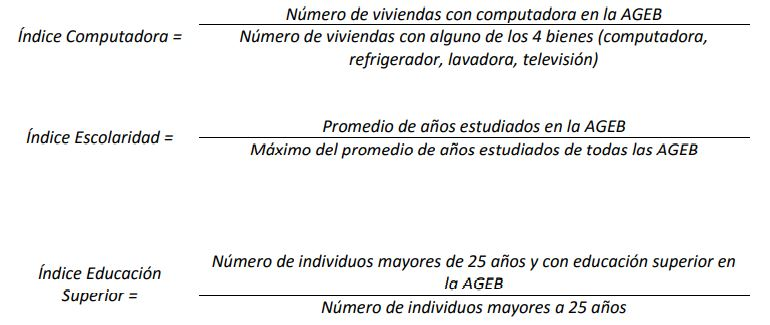

In [7]:
df_rec.columns.values

array(['ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC', 'AGEB',
       'MZA', 'POBTOT', 'POBFEM', 'POBMAS', 'P_0A2', 'P_0A2_F', 'P_0A2_M',
       'P_3YMAS', 'P_3YMAS_F', 'P_3YMAS_M', 'P_5YMAS', 'P_5YMAS_F',
       'P_5YMAS_M', 'P_12YMAS', 'P_12YMAS_F', 'P_12YMAS_M', 'P_15YMAS',
       'P_15YMAS_F', 'P_15YMAS_M', 'P_18YMAS', 'P_18YMAS_F', 'P_18YMAS_M',
       'P_3A5', 'P_3A5_F', 'P_3A5_M', 'P_6A11', 'P_6A11_F', 'P_6A11_M',
       'P_8A14', 'P_8A14_F', 'P_8A14_M', 'P_12A14', 'P_12A14_F',
       'P_12A14_M', 'P_15A17', 'P_15A17_F', 'P_15A17_M', 'P_18A24',
       'P_18A24_F', 'P_18A24_M', 'P_15A49_F', 'P_60YMAS', 'P_60YMAS_F',
       'P_60YMAS_M', 'REL_H_M', 'POB0_14', 'POB15_64', 'POB65_MAS',
       'PROM_HNV', 'PNACENT', 'PNACENT_F', 'PNACENT_M', 'PNACOE',
       'PNACOE_F', 'PNACOE_M', 'PRES2015', 'PRES2015_F', 'PRES2015_M',
       'PRESOE15', 'PRESOE15_F', 'PRESOE15_M', 'P3YM_HLI', 'P3YM_HLI_F',
       'P3YM_HLI_M', 'P3HLINHE', 'P3HLINHE_F', 'P3HLINHE_M', 'P3HLI_HE',
       'P

In [8]:
df_rec.dtypes.head(10)

ENTIDAD    object
NOM_ENT    object
MUN        object
NOM_MUN    object
LOC        object
NOM_LOC    object
AGEB       object
MZA        object
POBTOT      int64
POBFEM     object
dtype: object

In [9]:
df_rec['ENTIDAD'].unique()

array(['09'], dtype=object)

In [10]:
#Creación de clave cvegeo 
df_rec['CVEGEO']=df_rec['ENTIDAD'].astype(str)+df_rec.MUN.astype(str)+df_rec.LOC.astype(str)+df_rec.AGEB
df_rec[['ENTIDAD','MUN','LOC','AGEB','CVEGEO']]

ENTIDAD  MUN   LOC  AGEB         CVEGEO
3          09  002  0001  0010  0900200010010
28         09  002  0001  0025  0900200010025
71         09  002  0001  003A  090020001003A
101        09  002  0001  0044  0900200010044
144        09  002  0001  0097  0900200010097
...       ...  ...   ...   ...            ...
65475      09  017  0001  1488  0901700011488
65506      09  017  0001  1492  0901700011492
65537      09  017  0001  1505  0901700011505
65582      09  017  0001  151A  090170001151A
65623      09  017  0001  1524  0901700011524

[2416 rows x 5 columns]

In [11]:
df_rec[['VPH_PC','VPH_REFRI','VPH_LAVAD','VPH_TV']].dtypes

VPH_PC       object
VPH_REFRI    object
VPH_LAVAD    object
VPH_TV       object
dtype: object

In [12]:
df_rec['viv_algunbien']=df_rec.VPH_PC.astype(int)+df_rec.VPH_REFRI.astype(int)+df_rec.VPH_LAVAD.astype(int)+df_rec.VPH_TV.astype(int)
df_rec.head()

ENTIDAD           NOM_ENT  MUN       NOM_MUN   LOC            NOM_LOC  \
3        09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
28       09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
71       09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
101      09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
144      09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   

     AGEB  MZA  POBTOT POBFEM  ... VPH_INTER VPH_STVP VPH_SPMVPI VPH_CVJ  \
3    0010  000    3183   1695  ...       692      313        221     145   
28   0025  000    5593   2915  ...      1203      478        349     238   
71   003A  000    4235   2232  ...       878      361        339     247   
101  0044  000    4768   2551  ...      1076      481        452     294   
144  0097  000    2176   1115  ...       507      276        260     153   

    VPH_SINRTV VPH_SINLTC VPH_SINCINT VPH_SINTIC         CVEGEO viv_algunbien  
3            8         14         148          5  0900200010010          3064  
28          28         68         393         14  0900200010025          5981  
71           5         12         250          0  090020001003A          4041  
101         10         17         254          0  0900200010044          4867  
144          4          3          70          0  0900200010097          2144  

[5 rows x 231 columns]

In [13]:
#Creamos variables '# de vivivendas con algunos de los 4 bienes' (compu, refri, lavadora o tele) restandoles a las viviendas
#totales habitadas las viviendas sin ningun bien
df_rec['VPH_CONALGBIEN']=df_rec['VIVPAR_HAB'].astype(int)-df_rec['VPH_SNBIEN'].astype(int)

In [14]:
df_rec[['VPH_CONALGBIEN','VIVPAR_HAB','VPH_SNBIEN']].sort_values(by='VPH_CONALGBIEN', ascending=False)

VPH_CONALGBIEN VIVPAR_HAB VPH_SNBIEN
38229            6294       6297          3
9732             4171       4171          0
40280            4051       4057          6
62555            3873       3879          6
5789             3750       3769         19
...               ...        ...        ...
60662               0          0          0
60714               0          0          0
51005               0          0          0
60749               0          0          0
63233               0          0          0

[2416 rows x 3 columns]

In [15]:
df_rec['GRAPROES'].astype(float).describe()

count   2416.00
mean      11.64
std        1.97
min        0.00
25%       10.35
50%       11.40
75%       13.16
max       16.15
Name: GRAPROES, dtype: float64

In [16]:
df_rec['GRAPROES'].astype(float).max()

16.15

In [17]:
df_rec['GRAPROES'].astype(float).mean()

11.64041804635758

In [18]:
df_rec['GRAPROES_max']= max(df_rec['GRAPROES'].astype(float))
df_rec

ENTIDAD           NOM_ENT  MUN              NOM_MUN   LOC  \
3          09  Ciudad de México  002         Azcapotzalco  0001   
28         09  Ciudad de México  002         Azcapotzalco  0001   
71         09  Ciudad de México  002         Azcapotzalco  0001   
101        09  Ciudad de México  002         Azcapotzalco  0001   
144        09  Ciudad de México  002         Azcapotzalco  0001   
...       ...               ...  ...                  ...   ...   
65475      09  Ciudad de México  017  Venustiano Carranza  0001   
65506      09  Ciudad de México  017  Venustiano Carranza  0001   
65537      09  Ciudad de México  017  Venustiano Carranza  0001   
65582      09  Ciudad de México  017  Venustiano Carranza  0001   
65623      09  Ciudad de México  017  Venustiano Carranza  0001   

                 NOM_LOC  AGEB  MZA  POBTOT POBFEM  ... VPH_SPMVPI VPH_CVJ  \
3      Total AGEB urbana  0010  000    3183   1695  ...        221     145   
28     Total AGEB urbana  0025  000    5593   2915  ...        349     238   
71     Total AGEB urbana  003A  000    4235   2232  ...        339     247   
101    Total AGEB urbana  0044  000    4768   2551  ...        452     294   
144    Total AGEB urbana  0097  000    2176   1115  ...        260     153   
...                  ...   ...  ...     ...    ...  ...        ...     ...   
65475  Total AGEB urbana  1488  000    1079    564  ...         59      41   
65506  Total AGEB urbana  1492  000     900    475  ...         40      25   
65537  Total AGEB urbana  1505  000    2513   1346  ...        375     197   
65582  Total AGEB urbana  151A  000    2248   1208  ...        313     156   
65623  Total AGEB urbana  1524  000    4295   2229  ...        270     204   

      VPH_SINRTV VPH_SINLTC VPH_SINCINT VPH_SINTIC         CVEGEO  \
3              8         14         148          5  0900200010010   
28            28         68         393         14  0900200010025   
71             5         12         250          0  090020001003A   
101           10         17         254          0  0900200010044   
144            4          3          70          0  0900200010097   
...          ...        ...         ...        ...            ...   
65475          6         15          87          0  0901700011488   
65506         19         44          79          8  0901700011492   
65537          3          7          98          0  0901700011505   
65582          5          7         100          0  090170001151A   
65623         14         32         267          3  0901700011524   

      viv_algunbien VPH_CONALGBIEN GRAPROES_max  
3              3064            860        16.15  
28             5981           1637        16.15  
71             4041           1179        16.15  
101            4867           1364        16.15  
144            2144            590        16.15  
...             ...            ...          ...  
65475           869            284        16.15  
65506           712            239        16.15  
65537          2891            809        16.15  
65582          2512            717        16.15  
65623          3944           1203        16.15  

[2416 rows x 233 columns]

In [19]:
#Variable indice escolar
df_rec['indice_escolar']=df_rec['GRAPROES'].astype(float)/df_rec['GRAPROES'].astype(float).max()
df_rec.head()

ENTIDAD           NOM_ENT  MUN       NOM_MUN   LOC            NOM_LOC  \
3        09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
28       09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
71       09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
101      09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
144      09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   

     AGEB  MZA  POBTOT POBFEM  ... VPH_CVJ VPH_SINRTV VPH_SINLTC VPH_SINCINT  \
3    0010  000    3183   1695  ...     145          8         14         148   
28   0025  000    5593   2915  ...     238         28         68         393   
71   003A  000    4235   2232  ...     247          5         12         250   
101  0044  000    4768   2551  ...     294         10         17         254   
144  0097  000    2176   1115  ...     153          4          3          70   

    VPH_SINTIC         CVEGEO viv_algunbien VPH_CONALGBIEN GRAPROES_max  \
3            5  0900200010010          3064            860        16.15   
28          14  0900200010025          5981           1637        16.15   
71           0  090020001003A          4041           1179        16.15   
101          0  0900200010044          4867           1364        16.15   
144          0  0900200010097          2144            590        16.15   

    indice_escolar  
3             0.71  
28            0.66  
71            0.65  
101           0.69  
144           0.73  

[5 rows x 234 columns]

In [20]:
df_rec[['GRAPROES','indice_escolar']]

GRAPROES  indice_escolar
3        11.52            0.71
28       10.73            0.66
71       10.55            0.65
101      11.07            0.69
144      11.74            0.73
...        ...             ...
65475     9.44            0.58
65506      7.5            0.46
65537    12.53            0.78
65582    12.03            0.74
65623    10.87            0.67

[2416 rows x 2 columns]

In [21]:
#Creamos la variable de Poblacion de 0 a 24 anhos 
df_rec['p_0a24']=df_rec.P_0A2.astype(int)+df_rec.P_3A5.astype(int)+df_rec.P_6A11.astype(int)+df_rec.P_12A14.astype(int)+df_rec.P_15A17.astype(int)+df_rec.P_18A24.astype(int)
df_rec['p_25mas']=df_rec['POBTOT']-df_rec['p_0a24']
df_rec.head()

ENTIDAD           NOM_ENT  MUN       NOM_MUN   LOC            NOM_LOC  \
3        09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
28       09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
71       09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
101      09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
144      09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   

     AGEB  MZA  POBTOT POBFEM  ... VPH_SINLTC VPH_SINCINT VPH_SINTIC  \
3    0010  000    3183   1695  ...         14         148          5   
28   0025  000    5593   2915  ...         68         393         14   
71   003A  000    4235   2232  ...         12         250          0   
101  0044  000    4768   2551  ...         17         254          0   
144  0097  000    2176   1115  ...          3          70          0   

            CVEGEO viv_algunbien VPH_CONALGBIEN GRAPROES_max indice_escolar  \
3    0900200010010          3064            860        16.15           0.71   
28   0900200010025          5981           1637        16.15           0.66   
71   090020001003A          4041           1179        16.15           0.65   
101  0900200010044          4867           1364        16.15           0.69   
144  0900200010097          2144            590        16.15           0.73   

    p_0a24 p_25mas  
3      802    2381  
28    1557    4036  
71    1250    2985  
101   1354    3414  
144    572    1604  

[5 rows x 236 columns]

In [22]:
df_rec[['P18YM_PB','P_18A24','P18A24A','p_25mas']]

P18YM_PB P_18A24 P18A24A  p_25mas
3         1751     303     161     2381
28        2575     521     213     4036
71        1923     425     211     2985
101       2437     487     222     3414
144       1224     204      99     1604
...        ...     ...     ...      ...
65475      332     107      28      652
65506      224      95      21      542
65537     1544     291     162     1681
65582     1248     242     119     1473
65623     1938     468     218     2850

[2416 rows x 4 columns]

In [23]:
#Población de 18 años y más con educación posbásica - Población de 18 a 24 años que asiste a la escuela
df_rec['P25YM_EDUSUP']=df_rec['P18YM_PB'].astype(int)-df_rec['P18A24A'].astype(int)
df_rec[['P18YM_PB','P18A24A','P25YM_EDUSUP']]

P18YM_PB P18A24A  P25YM_EDUSUP
3         1751     161          1590
28        2575     213          2362
71        1923     211          1712
101       2437     222          2215
144       1224      99          1125
...        ...     ...           ...
65475      332      28           304
65506      224      21           203
65537     1544     162          1382
65582     1248     119          1129
65623     1938     218          1720

[2416 rows x 3 columns]

In [24]:
df_indices=df_rec[['CVEGEO','VPH_PC','VPH_CONALGBIEN','GRAPROES',
                     'GRAPROES_max','P25YM_EDUSUP','p_25mas']]
df_indices

CVEGEO VPH_PC  VPH_CONALGBIEN GRAPROES  GRAPROES_max  \
3      0900200010010    532             860    11.52         16.15   
28     0900200010025    930            1637    10.73         16.15   
71     090020001003A    641            1179    10.55         16.15   
101    0900200010044    845            1364    11.07         16.15   
144    0900200010097    399             590    11.74         16.15   
...              ...    ...             ...      ...           ...   
65475  0901700011488    111             284     9.44         16.15   
65506  0901700011492    108             239      7.5         16.15   
65537  0901700011505    570             809    12.53         16.15   
65582  090170001151A    488             717    12.03         16.15   
65623  0901700011524    644            1203    10.87         16.15   

       P25YM_EDUSUP  p_25mas  
3              1590     2381  
28             2362     4036  
71             1712     2985  
101            2215     3414  
144            1125     1604  
...             ...      ...  
65475           304      652  
65506           203      542  
65537          1382     1681  
65582          1129     1473  
65623          1720     2850  

[2416 rows x 7 columns]

In [25]:
#Creamos los 3 indices que ocuparemos para construir el NSE > indice computadora, indice escolaridad e indice educacion superior

#indice computadora= # de viviendas con computadora \ # de viviendas con alguno de los 4 bienes (compu, refri, lavadora, tele)
df_indices['IND_COMP']=df_indices['VPH_PC'].astype(int) / df_indices['VPH_CONALGBIEN']

#indice escolaridad= Prom. anhos estudiados \ Max. del promedio de a;os estudiados en todos los AGEB
df_indices['IND_ESCO']=df_indices['GRAPROES'].astype(float) / df_indices['GRAPROES_max']

#indice educacion superior= Número de individuos >25 años y con educación superior \ # de viviendas con alguno de los 4 bienes 
df_indices['IND_EDUS']=df_indices['P25YM_EDUSUP'] / df_indices['VPH_CONALGBIEN']


C:\Users\mafer\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\mafer\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mafer\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [26]:
df_indices

CVEGEO VPH_PC  VPH_CONALGBIEN GRAPROES  GRAPROES_max  \
3      0900200010010    532             860    11.52         16.15   
28     0900200010025    930            1637    10.73         16.15   
71     090020001003A    641            1179    10.55         16.15   
101    0900200010044    845            1364    11.07         16.15   
144    0900200010097    399             590    11.74         16.15   
...              ...    ...             ...      ...           ...   
65475  0901700011488    111             284     9.44         16.15   
65506  0901700011492    108             239      7.5         16.15   
65537  0901700011505    570             809    12.53         16.15   
65582  090170001151A    488             717    12.03         16.15   
65623  0901700011524    644            1203    10.87         16.15   

       P25YM_EDUSUP  p_25mas  IND_COMP  IND_ESCO  IND_EDUS  
3              1590     2381      0.62      0.71      1.85  
28             2362     4036      0.57      0.66      1.44  
71             1712     2985      0.54      0.65      1.45  
101            2215     3414      0.62      0.69      1.62  
144            1125     1604      0.68      0.73      1.91  
...             ...      ...       ...       ...       ...  
65475           304      652      0.39      0.58      1.07  
65506           203      542      0.45      0.46      0.85  
65537          1382     1681      0.70      0.78      1.71  
65582          1129     1473      0.68      0.74      1.57  
65623          1720     2850      0.54      0.67      1.43  

[2416 rows x 10 columns]

In [27]:
df_indices=df_indices[['CVEGEO','IND_COMP','IND_ESCO','IND_EDUS']]
df_indices

CVEGEO  IND_COMP  IND_ESCO  IND_EDUS
3      0900200010010      0.62      0.71      1.85
28     0900200010025      0.57      0.66      1.44
71     090020001003A      0.54      0.65      1.45
101    0900200010044      0.62      0.69      1.62
144    0900200010097      0.68      0.73      1.91
...              ...       ...       ...       ...
65475  0901700011488      0.39      0.58      1.07
65506  0901700011492      0.45      0.46      0.85
65537  0901700011505      0.70      0.78      1.71
65582  090170001151A      0.68      0.74      1.57
65623  0901700011524      0.54      0.67      1.43

[2416 rows x 4 columns]

In [28]:
#Matriz de correlaciones para verificar que todos los indices correlacionen entre si 
corr =df_indices.corr()
corr

IND_COMP  IND_ESCO  IND_EDUS
IND_COMP      1.00      0.78      0.92
IND_ESCO      0.78      1.00      0.69
IND_EDUS      0.92      0.69      1.00

In [29]:
data=df_indices[['IND_COMP','IND_ESCO','IND_EDUS']]
data

IND_COMP  IND_ESCO  IND_EDUS
3          0.62      0.71      1.85
28         0.57      0.66      1.44
71         0.54      0.65      1.45
101        0.62      0.69      1.62
144        0.68      0.73      1.91
...         ...       ...       ...
65475      0.39      0.58      1.07
65506      0.45      0.46      0.85
65537      0.70      0.78      1.71
65582      0.68      0.74      1.57
65623      0.54      0.67      1.43

[2416 rows x 3 columns]

In [30]:
# Count the number of NaNs each column has.
nans=pd.isnull(data).sum()
nans[nans>0]

IND_COMP    13
IND_EDUS    11
dtype: int64

In [31]:
data[data.isin([np.inf, -np.inf]).any(1)]

IND_COMP  IND_ESCO  IND_EDUS
9140        NaN      0.00       inf
51005       inf      0.85       inf
60714       inf      0.83       inf
60749       NaN      0.74       inf

In [32]:
data['IND_EDUS']=data['IND_EDUS'].replace([np.inf, -np.inf], np.nan)

C:\Users\mafer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
data

IND_COMP  IND_ESCO  IND_EDUS
3          0.62      0.71      1.85
28         0.57      0.66      1.44
71         0.54      0.65      1.45
101        0.62      0.69      1.62
144        0.68      0.73      1.91
...         ...       ...       ...
65475      0.39      0.58      1.07
65506      0.45      0.46      0.85
65537      0.70      0.78      1.71
65582      0.68      0.74      1.57
65623      0.54      0.67      1.43

[2416 rows x 3 columns]

In [34]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer
# One Hot Encoding and nan transformation
#data = pd.get_dummies(data)
#data

In [35]:
# Count the column types
data.dtypes
data
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)

C:\Users\mafer\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [36]:
#imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
#imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#SimpleImputer()
#imp = SimpleImputer(strategy="most_frequent")

In [37]:
imp

Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
        verbose=0)

In [38]:
imp.fit(data) 

Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
        verbose=0)

In [39]:
#data= imp.fit_transform(data)
data = imp.fit_transform(data[['IND_COMP','IND_ESCO','IND_EDUS']])

In [40]:
data

array([[0.61860465, 0.71331269, 1.84883721],
       [0.5681124 , 0.66439628, 1.44288332],
       [0.54368109, 0.65325077, 1.45207803],
       ...,
       [0.70457355, 0.77585139, 1.70828183],
       [0.68061367, 0.74489164, 1.57461646],
       [0.53532835, 0.67306502, 1.42975894]])

In [43]:
pca = PCA(whiten=True)
pca.fit(data)
#variance = pd.DataFrame(pca.explained_variance_ratio_)
#np.cumsum(pca.explained_variance_ratio_)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
variance = pd.DataFrame(pca.explained_variance_ratio_)
acumulada=np.cumsum(pca.explained_variance_ratio_)